# 6.S083 / 18.S190 Spring 2020: Problem set 3

Submission deadline: Tuesday April 21, 2020 at 11:59pm.


In this problem set, we will develop our first proper model that exhibits an **epidemic
outbreak**.

We will develop a **stochastic** (probabilistic) model of an infection propagating in a population  that is **well mixed**, i.e. in which everyone is in contact with everyone else.
An example of this would be a small school or university in which people are
constantly moving around and interacting with each other.

As usual, we will make modelling assumptions that allow us to reach the goal as fast and simply as possible.

The model is an **individual-based** or **agent-based** model -- in other words,
we explicitly keep track of each individual in the population and what their
infection status is. However, we will not keep track of their position in space;
we will just assume that there is some mechanism by which they interact with
other individuals which we do not include in the model (for now).

## Exercise 1: Modelling the spread of an infection or rumour

In this exercise we will model the spread of an infection or rumour in which
there is no recovery via a stochastic model, which we will implement in a Monte Carlo
simulation (i.e. a simulation that involves generating random numbers).

We will call the individuals **agents**.


1. Julia has a data type called an [**enumerated type**](https://en.wikipedia.org/wiki/Enumerated_type). Variables of this type can only take one of a pre-defined set of values; we will use this to model the possible internal state of an agent.

    The code to define an enum is as follows:

    ```julia
    @enum InfectionStatus S I R
    ```

    This defines a new type `InfectionStatus`, as well as names `S`, `I` and `R` that are the only possible values that a variable of this type can take.

    Define a variable `x` equal to `S`. What is its type?

2. Convert `x` to an integer using the `Int` function. What value does it have? What values do `I` and `R` have?

3. Take $N=100$. Make an array `agents` whose $i$th entry is the status of agent
number $i$. Make them all initially susceptible.

4. Now choose a single agent at random and make it infectious. (Hint: Use the
    `rand` function with a range to choose the index of the infectious agent.)

5. Write a function `step!` that takes a `Vector` `agents` and a probability `p_I`
as arguments.  This function may *modify* the content of `agents` to implement one step of the infection dynamics.

    1. Choose an agent $i$ at random.
    2. If $i$ is not infectious then nothing happens on this step so you can just `return`
 from the function.
     3. Choose another agent $j$ at random. Make sure that $i \neq j$. To do so, repeat this
    choice *until* $i \neq j$.
    4. If $j$ is not infected then $i$ infects $j$ with probability $p_I$.

6. Write a function `sweep!`. It runs `step!` $N$ times, where $N$ is the number of agents. Thus each agent acts, on average, once per sweep. One sweep is thus the unit
of time in our Monte Carlo simulation.

7. Write a function `infection_simulation`. It should take $N$ and $p_I$ as arguments,
as well as $T$, the total number of steps.

    1. First generate the `Vector` `agents` of length $N$ and a `Vector` `Is` to store
    the number of infectious individuals at each step.

    2. Run `sweep!` a number $T$ of times. Calculate the total number of infectious
    agents at the end of each step and store that number in `Is`.

    3. Return `Is` as the output of the function.

8. Run your simulation 50 times with $N=100$ and collect the data in a `Vector` of `Vector`s called `results`, using $p_I = 0.02$ and $T = 1000$.

    Plot each of the 50 graphs on the same plot using transparency 0.5.

9. Calculate the mean trajectory using the `mean` function applied to `results`. [This "just works" since `mean` is implmented in a generic way!] Add it to the plot using a heavier line.

10. Calculate the standard deviation $\sigma$ of $I$ at each step. [This should thus be a *vector.] Add this to the plot using **error bars**, using the option `yerr=σ` in the plot command; use transparency.

    This should confirm that the distribution of $I$ at each step is pretty wide!

9. You should see that the mean behaves in a similar way to what we saw in lectures using a *deterministic* model. So what is the deterministic model possibly describing, in terms of the stochastic model?

In [1]:
@enum InfectionStatus S I R

In [2]:
x = S
@show typeof(x)
@show Int(x)

typeof(x) = InfectionStatus
Int(x) = 0


0

In [3]:
function new_agents(n)
    agents = Vector()
    for i in 1:n
        push!(agents,S)
    end
    agents[rand(1:n)] = I
    return agents
end

new_agents (generic function with 1 method)

In [4]:
function step!(agents,p_I)
    n = size(agents)[1]
    i = rand(1:n)
    if !(agents[i] == I)
        return
    end
    j = i
    while j == i
        j = rand(1:n)
    end
    if agents[j] == I
        return
    end
    if rand() < p_I
        agents[j] = I
    end
    return
end

step! (generic function with 1 method)

In [5]:
function sweep!(agents,p_I)
    n = size(agents)[1]
    for i in 1:n
        step!(agents,p_I)
    end
end

sweep! (generic function with 1 method)

In [6]:
function count_Is(agents)
    count = 0
    for each in agents
        if each == I
            count += 1
        end
    end
    return count
end

count_Is (generic function with 1 method)

In [7]:
function infection_simulation(n,p_I,t)
    agents = new_agents(n)
    Is = [1]
    for i in 1:t
        sweep!(agents,p_I)
        count = count_Is(agents)
        push!(Is,count)
    end
    return Is
end

infection_simulation (generic function with 1 method)

In [8]:
using Plots
using Statistics

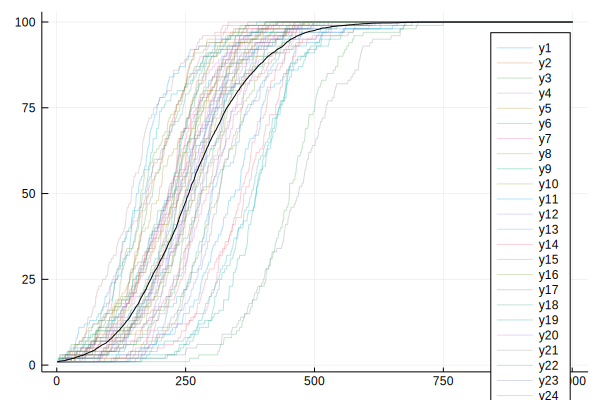

In [9]:
runs = 50
n = 100
p_I = 0.02
t = 1000
results = []
for run in 1:runs
    push!(results,infection_simulation(n,p_I,t))
end
p = plot()
for r in results
    plot!(p,r,alpha = 0.3)
end
m = mean(results)
plot!(p,m,color = "black")
p

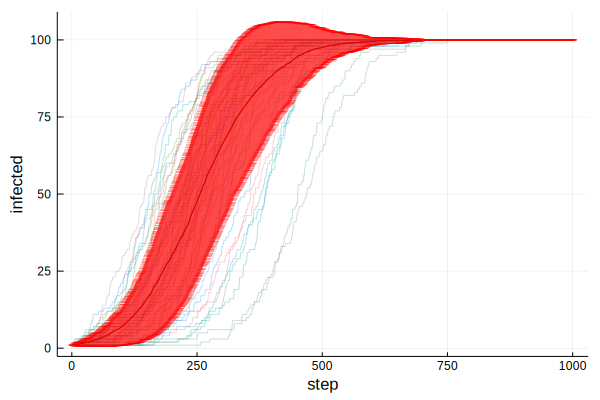

In [10]:
sigma = std(results)
p = plot(xlabel = "step",ylabel = "infected",leg=false)
for r in results
    plot!(p,r,alpha = 0.3)
end
m = mean(results)
plot!(p,m,color = "black")
plot!(p,m,color = "red", alpha = 0.5, yerr = sigma)
p

Shows that on average the spread of a disease will look like the mean of this distribution

## Exercise 2: Agent type

Suppose we want to track more information about each agent, e.g. how many other agents were infected by that agent. We could just create an additional array with that information in, but we will need to pass that around and will start to lose track of what belongs together.

Instead a good solution is to define a custom composite type.


1. Define a mutable type `Agent` as follows:

    ```jl
    mutable struct Agent
        status::InfectionStatus
        num_infected::Int
    end
    ```

2. Define a method of the constructor of `Agent` that takes no arguments and sets the status to `S` and
the number infected to 0.

3. Make an array `agents` of `Agent`s. Set the first one's infection status to `I`.

4. Rewrite your code from Exercise 1 to use the new `Agent` type. Now when your functions accept an `agents`
vector, they should assume that that represents a `Vector` of `Agent` objects.

    You can enforce this using a function signature like

    ```jl
    function f(agents::Vector{Agent})
    end
    ```

5. Update an agent's `num_infected` field whenever it infects another agent.

6. At the end of the simulation, extract the probability distribution of the "number of agents infected", using your code from Exercise 1 of Problem Set 2.

7. Plot the probability distribution. What kind of distribution does it seem to be? You will need to think about how to visualize this.

In [11]:
mutable struct Agent
    status::InfectionStatus
    num_infected::Int
end
Agent(I) = Agent(I,0)
Agent() = Agent(S,0)

Agent

In [12]:
function new_agents(n)
    agents = Vector{Agent}()
    push!(agents,Agent(I))
    for i in 2:n
        push!(agents,Agent())
    end
    return agents
end

new_agents (generic function with 1 method)

In [13]:
function step!(agents::Vector{Agent},p_I)
    n = size(agents)[1]
    i = rand(1:n)
    if !(agents[i].status == I)
        return
    end
    j = i
    while j == i
        j = rand(1:n)
    end
    if agents[j].status == I
        return
    end
    if rand() < p_I
        agents[j].status = I
        agents[i].num_infected += 1
    end
    return
end

step! (generic function with 2 methods)

In [14]:
function sweep!(agents::Vector{Agent},p_I)
    n = size(agents)[1]
    for i in 1:n
        step!(agents,p_I)
    end
end

sweep! (generic function with 2 methods)

In [15]:
function count_Is(agents::Vector{Agent})
    count = 0
    for each in agents
        if each.status == I
            count += 1
        end
    end
    return count
end

count_Is (generic function with 2 methods)

In [16]:
function infection_simulation(n,p_I,t)
    agents = new_agents(n)
    Is = []
    for i in 1:t
        sweep!(agents,p_I)
        count = count_Is(agents)
        push!(Is,count)
    end
    return Is
end

infection_simulation (generic function with 1 method)

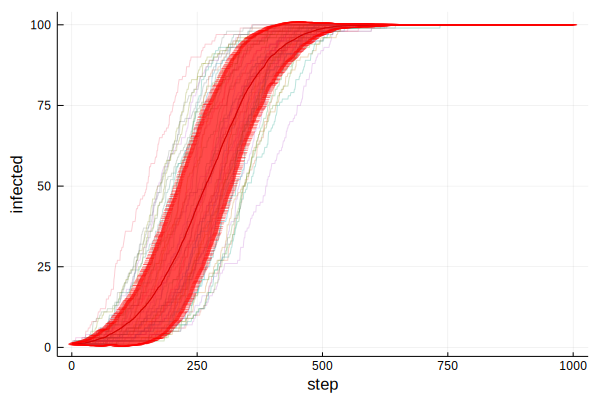

In [17]:
runs = 50
n = 100
p_I = 0.02
t = 1000
results = []
for run in 1:runs
    push!(results,infection_simulation(n,p_I,t))
end
sigma = std(results)
p = plot(xlabel = "step",ylabel = "infected",leg=false)
for r in results
    plot!(p,r,alpha = 0.3)
end
m = mean(results)
plot!(p,m,color = "black")
plot!(p,m,color = "red", alpha = 0.5, yerr = sigma)
p

In [18]:
function num_infected_dist_simulation(n,p_I,t)
    agents = new_agents(n)
    for i in 1:t
        sweep!(agents,p_I)
    end
    num_infected_arr = []
    for agent in agents
        push!(num_infected_arr, agent.num_infected)
    end
    return num_infected_arr
end

num_infected_dist_simulation (generic function with 1 method)

In [19]:
function counts(data)
    counts = Dict()
    for item in data
        if !(item in keys(counts))
            counts[item] = 0
        end
        counts[item] += 1
    end
    ks = collect(keys(counts))
    vs = collect(values(counts))
    p = sortperm(ks)
    ks[p],vs[p]
end
function probability_distribution(data)
    ks, vs = counts(data)
    total = sum(vs)
    probs = []
    for v in vs
        push!(probs,v/total)
    end
    return ks,probs
end

probability_distribution (generic function with 1 method)

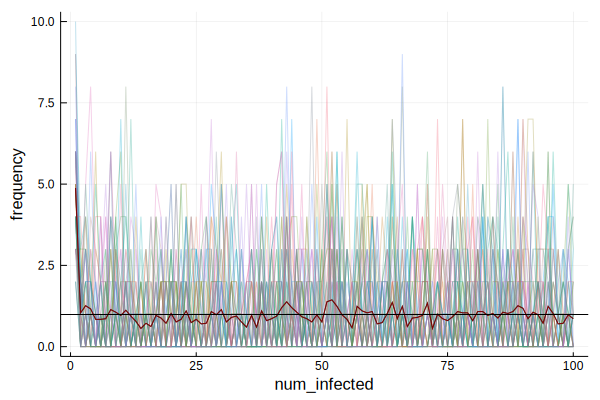

In [20]:
runs = 50
n = 100
p_I = 0.02
t = 1000
results = []
for run in 1:runs
    push!(results,num_infected_dist_simulation(n,p_I,t))
end
p = plot(xlabel = "num_infected",ylabel = "frequency", leg=false)
sigma = std(results)
for r in results
    plot!(p,r,alpha = 0.3)
end
m = mean(results)
dist_mean = mean(m)
plot!(p,m,color = "black")
plot!(p,m,color = "red", alpha = 0.5)
hline!([dist_mean],color = "black")
p

The frequency of how many people each person infects is approximately the same the mean of the frequencies is a represented as a horizontal lines 

## Exercise 3: Epidemic model

1. Add recovery to your model using an additional
parameter `p_R` in the `step!` and related functions.
Each agent should check if it is infected, and if so
it recovers with probability $p_R$ at each step.

    The function `simulation` should return vectors `Ss`, `Is` and `Rs` giving the time evolution of the numbers of $S$, $I$ and $R$, as well as the probability distribution of number of people infected.

2. Run the simulation with $N=1000$, $p_I = 0.1$ and $p_R = 0.01$ for time $T=1000$. Plot $S$, $I$ and $R$ as a function of time. You should see graphs that look familiar from the internet, with an epidemic outbreak, i.e. a significant fraction of infectious agents after a short time, which then recover.

3. Plot the distribution of `num_infected`. Does it have a recognisable shape?

4. Run the simulation 50 times and plot $I$ as a function of time for each, together with the mean over the 50 simulations (as you did in Exercise 2).

5. Describe 3 ways in which you could characterize the magnitude of the epidemic. Find these quantities for one of the runs of your simulation.

In [21]:
function step!(agents::Vector{Agent},p_I,p_R)
    n = size(agents)[1]
    i = rand(1:n)
    if !(agents[i].status == I)
        return
    end
    j = i
    while j == i
        j = rand(1:n)
    end
    if (agents[j].status == I || agents[j].status == R)
        return
    end
    if rand() < p_I
        agents[j].status = I
        agents[i].num_infected += 1
    end
    return
end

step! (generic function with 3 methods)

In [22]:
function count(agents::Vector{Agent},status)
    count = 0
    for each in agents
        if each.status == status
            count += 1
        end
    end
    return count
end

count (generic function with 1 method)

In [23]:
function sweep!(agents::Vector{Agent},p_I,p_R)
    for agent in agents
        if agent.status == I && rand() < p_R
            agent.status = R
        end
    end
    n = size(agents)[1]
    for i in 1:n
        step!(agents,p_I,p_R)
    end
end

sweep! (generic function with 3 methods)

In [24]:
function simulation(n,p_I,p_R,t)
    agents = new_agents(n)
    Ss = []
    Is = []
    Rs = []
    for i in 1:t
        sweep!(agents,p_I,p_R)
        push!(Ss,count(agents,S))
        push!(Is,count(agents,I))
        push!(Rs,count(agents,R))
    end
    num_infected_arr = []
    for agent in agents
        push!(num_infected_arr, agent.num_infected)
    end
    return Ss,Is,Rs,num_infected_arr
end

simulation (generic function with 1 method)

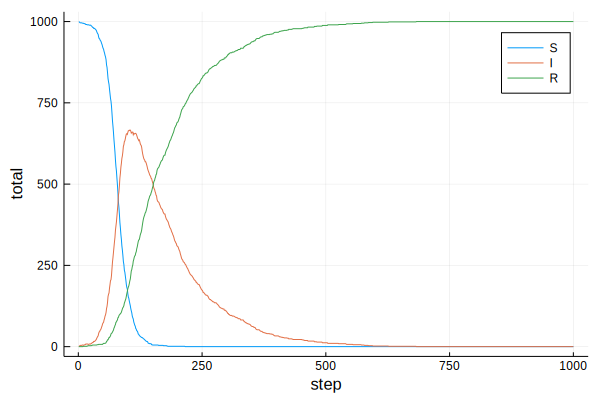

In [25]:
n = 1000
p_I = 0.1
p_R = 0.01
t = 1000

Ss,Is,Rs,num_infected_arr = simulation(n,p_I,p_R,t)
p = plot(xlabel = "step",ylabel = "total")
plot!(Ss, label = "S")
plot!(Is, label = "I")
plot!(Rs, label = "R")

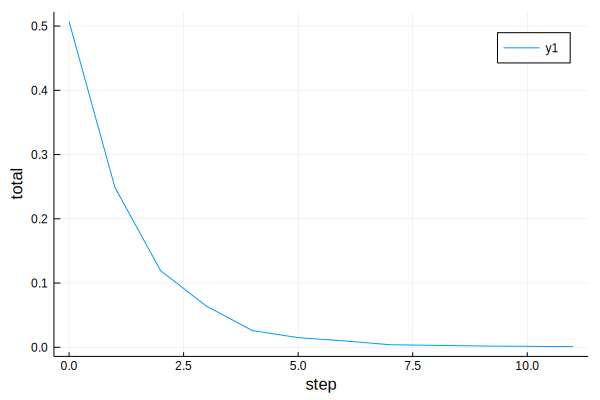

In [26]:
prob_dist = probability_distribution(num_infected_arr)
p = plot(prob_dist,xlabel = "step",ylabel = "total")

This looks like aexponential decay graph :0

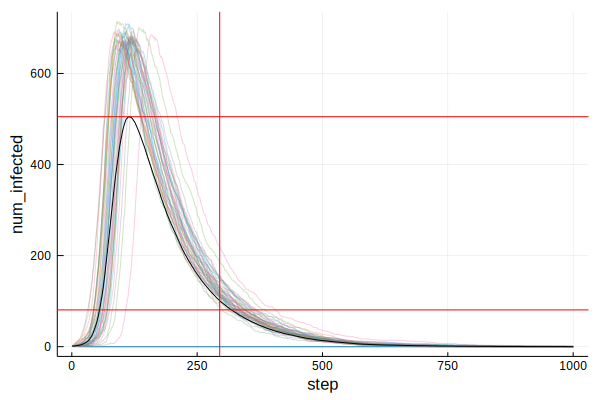

In [27]:
runs = 50
n = 1000
p_I = 0.1
p_R = 0.01
t = 1000
results = []
for run in 1:runs
    Ss,Is,Rs,num_infected_arr = simulation(n,p_I,p_R,t)
    push!(results,Is)
end
p = plot(xlabel = "step",ylabel = "num_infected", leg=false)
sigma = std(results)
for r in results
    plot!(p,r,alpha = 0.3)
end
m = mean(results)
dist_mean = mean(m)
plot!(p,m,color = "black")
max_val = 0
index = 0
for i in 1:size(m)[1]
    if max_val < m[i]
        max_val = m[i]
    end
    if n/10 < m[i]
        index = i
    end
end
hline!([dist_mean],color = "red")
hline!([max_val],color = "red")
vline!([index],color = "red")
p

One metric is obviously the maximum number of infected at all times because this coutl show the worst point of the while epidemic 
Another metric is when 10 percent of the population is still infected to show nearing the end of an epidemic like this
Another metric is the total average infected to see how many at any point  in the time frame will be infected